# Класс Research: эксперименты с пайплайнами. Часть 1
Предназначен для многократного запуска одних и тех же пайплайнов с различными параметрами. Это могут быть параметры модели, параметры используемых аугментаций и даже сами модели.

### Пример использования

Рассмотрим простой пример: запуск пайплайнов vgg7_train и vgg7_test на MNIST с различными значениями layout. Для каждого значения layout пайплайны запускаются 10 раз, каждый раз обучаясь "с нуля" 100 итераций. На каждой итераций выполняется один прогон vgg7_train и vgg7_test. В vgg7_train запоминаются значения loss, в vgg7_test - accuracy.

In [1]:
import sys

sys.path.append('..')
sys.path.append('../..')

from dataset import B, C, V, Config, F
from dataset.opensets import MNIST
from dataset.models.tf import VGG7

In [2]:
import tensorflow as tf

model_config = {
    'parameter': F(lambda batch: batch.images[0].shape),
    'session/config': tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)),
    'inputs/images': {
        'shape': (28, 28, 1),
        'type': 'float32',
        'name': 'reshaped_images'
    },
    'inputs/labels': {
        'classes': 10,
        'type': 'int32',
        'transform': 'ohe',
        'name': 'targets'
    },
    'input_block/inputs': 'images',
    'output/ops': ['accuracy'],
    'loss': 'ce',
    'optimizer': 'Adam'
}

feed_dict = {'images': B('images'),
             'labels': B('labels')}

Все параметры, которые мы хотим варьировать, должны быть заданы через config пайплайна, т.е. в пайплайне это параметр задаётся как C('parameter_name'). Поскольку мы хотим варьировать параметр конфигурации модели, весь model_config зададим в конфиге пайплайна:

In [3]:
pipeline_config = Config(model_config=model_config)

Config - это новый класс из dataset для удобной работы с вложенными словарями.

В init_model конфиг передадим как C('model_config'). Отметим, что сразу передать конфиг c {'layout': C('layout')} нельзя.

In [4]:
mnist = MNIST()

vgg7_train = (mnist.train.p
              .init_variable('loss', init_on_each_run=list)
              .init_model('dynamic', VGG7, 'model', C('model_config'))
              .train_model('model', feed_dict=feed_dict, fetches='loss', save_to=V('loss'), mode='a')
              .run(batch_size=8, shuffle=True, n_epochs=None, lazy=True)
             )

vgg7_test = (mnist.test.p
             .init_variable('accuracy', init_on_each_run=list)
             .import_model('model', C('import_model_from'))
             .predict_model('model', feed_dict=feed_dict, fetches='output_accuracy', save_to=V('accuracy'), mode='a')
             .run(batch_size=10, shuffle=True, n_epochs=None, lazy=True)
            )

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gz





Сетку параметров можно задать следующим образом:

In [5]:
grid_config = {'model_config/body/block/layout': ['cna', 'can', 'acn']}

Перебор конфигураций параметров будет организован следующим образом: из grid_config будет генерироваться конфигурация (словарь), которая будет добавляться к конфигурации пайплайна. В нашем примере будет производиться слияние model_config и словарей

In [6]:
# {'body/block/layout': 'cna'}
# {'body/block/layout': 'can'}
# {'body/block/layout': 'acn'}

In [7]:
from research import Research

mr = (Research()
     .add_pipeline(vgg7_train, variables='loss', config=pipeline_config, name='train')
     .add_pipeline(vgg7_test, variables='accuracy', import_model_from='train')
     .add_grid_config(grid_config)
     .run(n_reps=3, n_iters=100, n_jobs=2, name='my_research'))

Поскольку архитектура пайплайнов подразумевает импортирование модели из vgg7_train в vgg7_test, то в экшн import_model следует передать C('import_model_from'), а в метод add_pipeline класса Research передать параметр import_model_from с именем пайплайна под которым vgg7_train был добавлен в mr.

Далее мы более подробно разберём параметры метода run и требования к пайплайнам. n_jobs - это количество процессов, выполняющих параллельный запуск пайплайнов с разными конфигурациями. Результаты экспериментов будут лежать в папке 'my_research/results'. Для каждой конфигурации будет создана отдельная подпапка, в которой будут лежать n_reps файлов (если в ходе эксперимента ничего не поломалось). Каждый файл - это pickle.dump со значениями переменных после указанного числа итераций. Названия папок будут следующие:

In [8]:
# model_config/body/block/layout-cna
# model_config/body/block/layout-can
# model_config/body/block/layout-acn

В папке my_research будет лежать файл description c pickle.dump описания эксперимента и description_research.json с текстовым описанием.

Каждый результат будет представлен в следующем виде:

In [9]:
import pickle

res = []
for i in range(4):
    with open(r'my_research_1\results\model_config\body\block\layout_acn' + '\\'+ str(i), 'rb') as file:
        res.append(pickle.load(file))

In [10]:
res[0].keys(), res[0]['train'].keys(), res[0]['ppl_1'].keys()

(dict_keys(['ppl_1', 'train']), dict_keys(['loss']), dict_keys(['accuracy']))

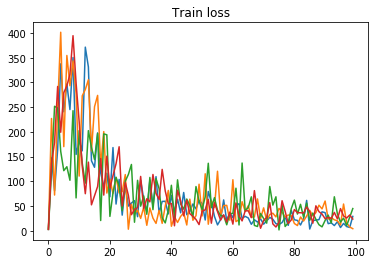

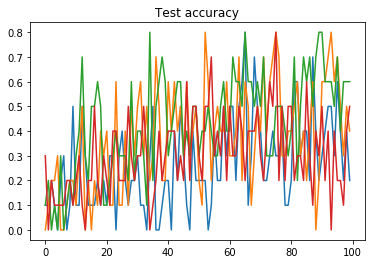

In [11]:
import matplotlib.pyplot as plt

for item in res:
    plt.plot(item['train']['loss'])
plt.title('Train loss')
plt.show()

for item in res:
    plt.plot(item['ppl_1']['accuracy'])
plt.title('Test accuracy')
plt.show()

Плохо, что '/' будет командой по созданию подпапок. Можно было бы просто заменить его на какой-то другой символ, но кроме того, сами значения параметров могут быть более сложными. Например, grid может выглядеть следующим образом:

In [12]:
grid = {
    'model_config/head/units': [[100, 100, 10], [100, 120, 10], [4096, 4096, 10]],
    'model_config/body/block/layout': ['cna', 'can', 'acn']
}

Тогда строчные представления элементов сетки параметров будут иметь вид

In [13]:
# model_config/body/block/layout-cna_model_config/head/units-[100, 100, 10]
# model_config/body/block/layout-cna_model_config/head/units-[100, 120, 10]
# model_config/body/block/layout-cna_model_config/head/units-[4096, 4096, 10]
# model_config/body/block/layout-can_model_config/head/units-[100, 100, 10]
# model_config/body/block/layout-can_model_config/head/units-[100, 120, 10]
# model_config/body/block/layout-can_model_config/head/units-[4096, 4096, 10]
# model_config/body/block/layout-acn_model_config/head/units-[100, 100, 10]
# model_config/body/block/layout-acn_model_config/head/units-[100, 120, 10]
# model_config/body/block/layout-acn_model_config/head/units-[4096, 4096, 10]

Слишком сложная структура, хотя варьируемых параметров всего 2. Избежать этого помогут классы KV, Option и Grid.

### Классы KV, Option и Grid
Введены для удобной работы с сетками параметров, из которых будут генерироваться конфигурации пайплайнов для экспериментов.

In [14]:
from grid import KV, Option, Grid

KV (key: value) - это просто пара значение-псевдоним. Добавим псевдонимы к названиям параметров:

In [15]:
p1 = KV('model_config/body/block/layout', 'layout')
p2 = KV('model_config/head/units', 'head')

In [16]:
p1.value, p1.alias

('model_config/body/block/layout', 'layout')

Также добавим псевдонимы к значениям 'model_config/head/units':

In [17]:
v1 = KV([100, 100, 10], 'small')
v2 = KV([4096, 4096, 10], 'big')

Option - это пара параметр-список значений, которые хотим перебрать. Как параметр, так и значения могут быть представлены как эеземпляры KV.

In [18]:
op1 = Option(p1, ['cna', 'acn', 'can'])
op2 = Option(p2, [v1, v2])

In [19]:
op1.option(), op1.alias()

({'model_config/body/block/layout': ['cna', 'acn', 'can']},
 {'layout': ['cna', 'acn', 'can']})

In [20]:
op2.option(), op2.alias()

({'model_config/head/units': [[100, 100, 10], [4096, 4096, 10]]},
 {'head': ['small', 'big']})

Экземпляры Option можно складывать и перемножать. Результатом будет экземпляр класса Grid.

In [21]:
op1 * op2

Grid([[{'layout': ['cna', 'acn', 'can']}, {'head': ['small', 'big']}]])

In [22]:
op1 + op2

Grid([[{'layout': ['cna', 'acn', 'can']}], [{'head': ['small', 'big']}]])

В начальном примере сетка просто создавалась из словаря:

In [23]:
grid = {
    'model_config/head/units': [[100, 100, 10], [100, 120, 10], [4096, 4096, 10]],
    'model_config/body/block/layout': ['cna', 'can', 'acn']
}

Grid(grid)

Grid([[{'model_config/body/block/layout': ['cna', 'can', 'acn']}, {'model_config/head/units': [[100, 100, 10], [100, 120, 10], [4096, 4096, 10]]}]])

На самом деле, Grid представляет собой следующую структуру:

$[[op_{11}, op_{12}, \dots, op_{1n_1}] \\
 \dots \\
 [op_{m1}, op_{m2}, \dots, op_{mn_m}]]$ 

При генерировании конфигураций опции внутри каждого списка декартово перемножаются, затем конфигурации всех списков конкатенируются. Это проще понять на примере:

In [24]:
list((op1 * op2).gen_configs())

[ConfigAlias({'layout': 'cna', 'head': 'small'}),
 ConfigAlias({'layout': 'cna', 'head': 'big'}),
 ConfigAlias({'layout': 'acn', 'head': 'small'}),
 ConfigAlias({'layout': 'acn', 'head': 'big'}),
 ConfigAlias({'layout': 'can', 'head': 'small'}),
 ConfigAlias({'layout': 'can', 'head': 'big'})]

In [25]:
list((op1 + op2).gen_configs())

[ConfigAlias({'layout': 'cna'}),
 ConfigAlias({'layout': 'acn'}),
 ConfigAlias({'layout': 'can'}),
 ConfigAlias({'head': 'small'}),
 ConfigAlias({'head': 'big'})]

Метод gen_configs класса Grid возвращает генератор конфигураций. Точнее, генератор создаёт объекты класса ConfigAlias. У этих объектов есть значение (объект класса Config), и псевдоним.

In [26]:
op3 = Option('new_parameter', ['value1', 'value2'])

In [27]:
grid = (op1 + op2) * op3
[item.config().flatten() for item in grid.gen_configs()]

[{'model_config/body/block/layout': 'cna', 'new_parameter': 'value1'},
 {'model_config/body/block/layout': 'cna', 'new_parameter': 'value2'},
 {'model_config/body/block/layout': 'acn', 'new_parameter': 'value1'},
 {'model_config/body/block/layout': 'acn', 'new_parameter': 'value2'},
 {'model_config/body/block/layout': 'can', 'new_parameter': 'value1'},
 {'model_config/body/block/layout': 'can', 'new_parameter': 'value2'},
 {'model_config/head/units': [100, 100, 10], 'new_parameter': 'value1'},
 {'model_config/head/units': [100, 100, 10], 'new_parameter': 'value2'},
 {'model_config/head/units': [4096, 4096, 10], 'new_parameter': 'value1'},
 {'model_config/head/units': [4096, 4096, 10], 'new_parameter': 'value2'}]

In [28]:
[item.alias() for item in grid.gen_configs()]

[{'layout': 'cna', 'new_parameter': 'value1'},
 {'layout': 'cna', 'new_parameter': 'value2'},
 {'layout': 'acn', 'new_parameter': 'value1'},
 {'layout': 'acn', 'new_parameter': 'value2'},
 {'layout': 'can', 'new_parameter': 'value1'},
 {'layout': 'can', 'new_parameter': 'value2'},
 {'head': 'small', 'new_parameter': 'value1'},
 {'head': 'small', 'new_parameter': 'value2'},
 {'head': 'big', 'new_parameter': 'value1'},
 {'head': 'big', 'new_parameter': 'value2'}]

Теперь, когда у конфигов есть псевдонимы, мы можем получить удобное представление для конфигурций:

In [29]:
[item.alias(as_string=True) for item in grid.gen_configs()]

['layout_cna-new_parameter_value1',
 'layout_cna-new_parameter_value2',
 'layout_acn-new_parameter_value1',
 'layout_acn-new_parameter_value2',
 'layout_can-new_parameter_value1',
 'layout_can-new_parameter_value2',
 'head_small-new_parameter_value1',
 'head_small-new_parameter_value2',
 'head_big-new_parameter_value1',
 'head_big-new_parameter_value2']